In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import transformers
from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
from transformers import AutoTokenizer, DataCollatorWithPadding
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pytorch_lightning as pl
import os.path
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import BertTokenizer, BertModel
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, DataCollatorWithPadding
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import TQDMProgressBar, ModelCheckpoint, EarlyStopping

2023-12-11 12:05:10.839850: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Data Preparation**

In [4]:
# Load the labeled data
labelled_data = pd.read_csv('/Users/vladandreichuk/Desktop/git_reps/practical-data-science-tutorial/data/Final-Dataset - finaldataset.csv')

In [5]:
# Load the test data
test_data = pd.read_csv('/Users/vladandreichuk/Desktop/git_reps/practical-data-science-tutorial/data/Draft-dataset - draftdataset.csv')

In [6]:
# Leave only columns of interest
labelled_data = labelled_data[['study_title','Confidence']]

In [7]:
# Leave only columns of interest
test_data = test_data[['study_id','study_title']]

In [8]:
test_data

,study_id,study_title
0,hm0001,The psychological impact of quarantine and how...
1,hm0002,"Global, regional, and national incidence, prev..."
2,hm0003,A novel coronavirus outbreak of global health ...
3,hm0004,COVID-19 and Italy: what next?
4,hm0005,Structural racism and health inequities in the...
...,...,...
1237,bem1238,Informing the Market: The Effect of Modern Inf...
1238,bem1239,Winning by Losing: Evidence on the Long-run Ef...
1239,bem1240,Employment and Wage Insurance within Firms: Wo...
1240,bem1241,Why Does Fast Loan Growth Predict Poor Perform...


In [9]:
# Round the labels to the nearest integer
labelled_data['Confidence'] = labelled_data['Confidence'].round().astype(int)

In [10]:
# Rename the columns
labelled_data.columns = ['body', 'label']

In [11]:
# Rename the columns
test_data.columns = ['study_id','body']

In [12]:
# Add a 'label' column of 0s, necessary for smooth implementation of the code below
test_data['label'] = 0

In [13]:
test_data 

,study_id,body,label
0,hm0001,The psychological impact of quarantine and how...,0
1,hm0002,"Global, regional, and national incidence, prev...",0
2,hm0003,A novel coronavirus outbreak of global health ...,0
3,hm0004,COVID-19 and Italy: what next?,0
4,hm0005,Structural racism and health inequities in the...,0
...,...,...,...
1237,bem1238,Informing the Market: The Effect of Modern Inf...,0
1238,bem1239,Winning by Losing: Evidence on the Long-run Ef...,0
1239,bem1240,Employment and Wage Insurance within Firms: Wo...,0
1240,bem1241,Why Does Fast Loan Growth Predict Poor Perform...,0


In [14]:
labelled_data

,body,label
0,COVID-19: the gendered impacts of the outbreak,3
1,COVID-19: towards controlling of a pandemic,1
2,Prevention and treatment of low back pain: evi...,4
3,Effect of early tranexamic acid administration...,4
4,Offline: COVID-19 is not a pandemic,4
...,...,...
95,The role and dimensions of authenticity in her...,2
96,Impact of crisis events on Chinese outbound to...,4
97,Effects of the Booking.com rating system: Brin...,4
98,Spillover effects of economic globalization on...,4


In [15]:
# Subtract 1 from labels so that they start from 0
labelled_data['label'] = labelled_data['label'] - 1

In [16]:
labelled_data['label'].value_counts()

label
1    35
3    30
2    21
0    12
4     2
Name: count, dtype: int64

In [17]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(labelled_data, test_size=0.2, random_state=42)

## **Model**

### **BERT Model**

In [18]:
epoch = 0


class BERT_unfreeze(pl.LightningModule):
    def __init__(self, weights, max_length, learning_rate=1e-5):
        """
        Lightning Module for fine-tuning BERT with unfreezing layers.

        Args:
            weights (torch.Tensor): Weights for NLLLoss.
            max_length (int): Maximum length of input sequences.
            learning_rate (float): Learning rate for optimizer.
        """
        super().__init__()
        self.save_hyperparameters()
        self.loss = nn.NLLLoss(weight=weights)
        self.max_length = max_length
        self.learning_rate = learning_rate
        self.training_step_loss = []
        self.validation_step_loss = []
        self.test_step_loss = []
        self.test_step_acc = []
        self.training_step_acc = []
        self.validation_step_acc = []

        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Freeze the pretrained layers except 1-3
        for layer in self.bert.encoder.layer[:9]:
            for param in layer.parameters():
                param.requires_grad = False

        # Dropout layer
        self.dropout = nn.Dropout(0.2)

        # ReLU activation function
        self.relu = nn.ReLU()

        # Dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # Dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 5)

        # Softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        """
        Forward pass of the model.

        Args:
            sent_id (torch.Tensor): Input sentence IDs.
            mask (torch.Tensor): Attention mask.

        Returns:
            torch.Tensor: Model predictions.
        """
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

    def configure_optimizers(self):
        """
        Configure optimizer and learning rate scheduler.

        Returns:
            dict: Dictionary containing optimizer and lr_scheduler.
        """
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = {
            "scheduler": ReduceLROnPlateau(
                optimizer, mode="min", factor=0.5, patience=3, verbose=1
            ),
            "monitor": "val_loss",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def export_metrics(self, acc, loss, step):
        """
        Export metrics to a CSV file.

        Args:
            acc (float): Accuracy.
            loss (torch.Tensor): Loss value.
            step (str): Training, validation, or test step.
        """
        metrics_filename = f"/Users/vladandreichuk/Desktop/git_reps/practical-data-science-tutorial/models/BERT_metrics/max_l{self.max_length}_lr{self.learning_rate}_{step}_metrics.csv"

        metrics_df = pd.DataFrame(
            [[epoch, acc, float(loss)]], columns=["epoch", "acc", "loss"]
        )

        if os.path.isfile(metrics_filename):
            metrics_in_data = pd.read_csv(metrics_filename)
            metrics_out_data = pd.concat([metrics_in_data, metrics_df])
            metrics_out_data.to_csv(metrics_filename, index=False)
        else:
            metrics_df.to_csv(metrics_filename, index=False)

    def training_step(self, train_batch, batch_idx):
        """
        Training step for the model.

        Args:
            train_batch (tuple): Batch of training data.
            batch_idx (int): Batch index.

        Returns:
            dict: Dictionary containing training metrics.
        """
        sent_id, mask, labels = train_batch
        preds = self(sent_id, mask)
        loss = self.loss(preds, labels)
        acc = torch.sum(labels == torch.argmax(preds, dim=1)).item() / len(labels)
        metrics = {"train_acc": acc, "loss": loss}
        self.training_step_loss.append(loss)
        self.training_step_acc.append(acc)
        return metrics

    def on_train_epoch_end(self):
        """
        Called at the end of each training epoch.
        """
        step = "train"
        # Compute loss and accuracy and export it
        loss = torch.stack(self.training_step_loss).mean()
        acc = sum(self.training_step_acc) / len(self.training_step_acc)
        self.export_metrics(acc, loss, step)
        self.training_step_loss.clear()
        self.training_step_acc.clear()

    def validation_step(self, val_batch, batch_idx):
        """
        Validation step for the model.

        Args:
            val_batch (tuple): Batch of validation data.
            batch_idx (int): Batch index.

        Returns:
            dict: Dictionary containing validation metrics.
        """
        sent_id, mask, labels = val_batch
        preds = self(sent_id, mask)
        loss, acc = self._shared_eval_step(val_batch, batch_idx)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics)
        self.validation_step_loss.append(loss)
        self.validation_step_acc.append(acc)
        return metrics

    def on_validation_epoch_end(self):
        """
        Called at the end of each validation epoch.
        """
        global epoch
        epoch = epoch + 1
        step = "val"
        # Compute loss and accuracy and export it
        loss = torch.stack(self.validation_step_loss).mean()
        acc = sum(self.validation_step_acc) / len(self.validation_step_acc)
        self.export_metrics(acc, loss, step)
        self.validation_step_loss.clear()
        self.validation_step_acc.clear()

    def test_step(self, test_batch, batch_idx):
        """
        Test step for the model.

        Args:
            test_batch (tuple): Batch of test data.
            batch_idx (int): Batch index.

        Returns:
            dict: Dictionary containing test metrics.
        """
        sent_id, mask, labels = test_batch
        preds = self(sent_id, mask)
        loss, acc = self._shared_eval_step(test_batch, batch_idx)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.export_metrics(acc, loss, "test")
        self.log_dict(metrics)
        self.test_step_loss.append(loss)
        return metrics

    def predict_step(self, predict_batch, batch_idx):
        """
        Prediction step for the model.

        Args:
            predict_batch (tuple): Batch of data for prediction.
            batch_idx (int): Batch index.

        Returns:
            torch.Tensor: Model predictions.
        """
        sent_id, mask, labels = predict_batch
        return self(sent_id, mask)

    def _shared_eval_step(self, batch, batch_idx):
        """
        Shared evaluation step for validation and test.

        Args:
            batch (tuple): Batch of data.
            batch_idx (int): Batch index.

        Returns:
            tuple: Tuple containing loss and accuracy.
        """
        sent_id, mask, labels = batch
        preds = self(sent_id, mask)
        loss = self.loss(preds, labels)
        acc = torch.sum(labels == torch.argmax(preds, dim=1)).item() / len(labels)
        return loss, acc

### **Data Loader**

In [19]:
class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32, max_length=256, test_nrows=None):
        """
        Lightning DataModule for handling data loading and tokenization.

        Args:
            batch_size (int): Batch size for data loaders.
            max_length (int): Maximum length of tokenized sequences.
            test_nrows (int): Number of rows to consider in the test set.
        """
        super().__init__()
        self.batch_size = batch_size
        self.max_length = max_length
        self.test_nrows = test_nrows
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def tokenize(self, df):
        """
        Tokenize the input dataframe and convert it to a TensorDataset.

        Args:
            df (pd.DataFrame): Input dataframe.

        Returns:
            TensorDataset: Tokenized and converted dataset.
        """
        tokens = self.tokenizer.__call__(
            df["body"].tolist(),
            padding=True,
            max_length=self.max_length,
            truncation=True,
        )

        # Convert the integer sequences to tensors.
        seq = torch.tensor(tokens["input_ids"])
        mask = torch.tensor(tokens["attention_mask"])
        if "label" in df.columns:
            y = torch.tensor(df["label"].tolist())
            return TensorDataset(seq, mask, y)
        else:
            return TensorDataset(seq, mask)

    def setup(self, stage):
        """
        Set up data for different stages: weight calculation, training, validation, testing, or prediction.

        Args:
            stage (str): Current stage.
        """
        if stage == "weight_calc":
            # For weight calculation, use the training data
            df_train = train_data
            class_weights = compute_class_weight(
                class_weight="balanced",
                classes=np.unique(df_train["label"]),
                y=df_train["label"],
            )
            self.weights = torch.tensor(class_weights, dtype=torch.float)

        if stage == "fit":
            # For training and validation, use the training and validation data
            df_train = train_data
            df_val = val_data

            self.train_data = self.tokenize(df_train)
            self.val_data = self.tokenize(df_val)

        if stage == "test" or stage == "predict":
            # For testing or prediction, use the test and labelled data
            df_test = test_data
            self.test_data = self.tokenize(df_test)
            self.train_val_data = self.tokenize(labelled_data)

    def get_weights(self):
        """
        Get class weights for the weighted loss function.

        Returns:
            torch.Tensor: Class weights.
        """
        return self.weights

    def train_dataloader(self):
        """
        Training data loader.

        Returns:
            DataLoader: Training data loader.
        """
        return DataLoader(self.train_data, drop_last=True, batch_size=self.batch_size)

    def train_val_dataloader(self):
        """
        Combined training and validation data loader for calculating metrics during training.

        Returns:
            DataLoader: Combined training and validation data loader.
        """
        return DataLoader(
            self.train_val_data, drop_last=True, batch_size=self.batch_size
        )

    def val_dataloader(self):
        """
        Validation data loader.

        Returns:
            DataLoader: Validation data loader.
        """
        return DataLoader(self.val_data, drop_last=True, batch_size=self.batch_size)

    def test_dataloader(self):
        """
        Test data loader.

        Returns:
            DataLoader: Test data loader.
        """
        return DataLoader(self.test_data, drop_last=True, batch_size=self.batch_size)

    def predict_dataloader(self):
        """
        Prediction data loader.

        Returns:
            DataLoader: Prediction data loader.
        """
        return DataLoader(self.test_data, drop_last=True, batch_size=self.batch_size)

### **Model Training**

In [20]:
def train_predict():
    # Initiate the model and set up the weights
    dm = DataModule(batch_size=5, max_length=512, test_nrows=None)
    dm.setup(stage="weight_calc")

    model = BERT_unfreeze(weights=dm.get_weights(), max_length=512, learning_rate=1e-4)

    # Initiate the trainer and fit the model
    trainer = pl.Trainer(
        default_root_dir="/Users/vladandreichuk/Desktop/git_reps/practical-data-science-tutorial/models/BERT_metrics",
        max_epochs=20,
        log_every_n_steps=10,
        gradient_clip_val=1.0,
        accelerator="auto",
        devices="1",
        callbacks=[
            EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, mode="min"),
            ModelCheckpoint(save_top_k=1, save_last=False, monitor="val_loss"),
            TQDMProgressBar(refresh_rate=10),
        ],
    )

    trainer.fit(model, dm)

    # Load the best checkpoint for prediction
    best_model_checkpoint = trainer.checkpoint_callback.best_model_path
    best_model = BERT_unfreeze.load_from_checkpoint(best_model_checkpoint)
    test_predictions = trainer.predict(best_model, dm)

    # Make predictions using the trained model on the training data
    train_predictions = trainer.predict(best_model, dm.train_val_dataloader())

    return test_predictions, train_predictions


test_predictions, train_predictions = train_predict()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/vladandreichuk/Desktop/git_reps/practical-data-science-tutorial/models/BERT_metrics/lightning_logs
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name    | Type       | Params
---------------------------------------
0 | loss    | NLLLoss    | 0     
1 | bert    | BertModel  | 109 M 
2 | dropout | Dropout    | 0     
3 | relu    | ReLU       | 0     
4 | fc1     | Linear     | 393 K 
5 | fc2     | Linear     | 2.6 K 
6 | softmax | LogSoftmax | 0     
---------------------------------------
46.1 M    Trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [86]:
import plotly.graph_objects as go


def bert_train_val_metrics(training_file, validation_file):
    """
    Generate and display interactive plots for training and validation metrics (accuracy and loss).

    Args:
        training_file (str): Path to the training metrics CSV file.
        validation_file (str): Path to the validation metrics CSV file.
    """
    # Read CSV files
    train_metrics = pd.read_csv(training_file)
    val_metrics = pd.read_csv(validation_file)

    # Create Subplots for Accuracy
    fig = go.Figure()

    # Plot Training and Validation Accuracy
    fig.add_trace(
        go.Scatter(
            x=train_metrics["epoch"],
            y=train_metrics["acc"],
            mode="lines",
            name="Training Accuracy",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=val_metrics["epoch"],
            y=val_metrics["acc"],
            mode="lines",
            name="Validation Accuracy",
        )
    )

    # Customize the layout for Accuracy
    fig.update_layout(
        title="Training and Validation Accuracy Over Epochs",
        xaxis_title="Epoch",
        yaxis_title="Accuracy",
        legend=dict(x=0, y=1),
        template="plotly_dark",
    )

    # Show the Accuracy plot
    fig.show()

    # Create another subplot for Loss
    fig_loss = go.Figure()

    # Plot Training and Validation Loss
    fig_loss.add_trace(
        go.Scatter(
            x=train_metrics["epoch"],
            y=train_metrics["loss"],
            mode="lines",
            name="Training Loss",
        )
    )
    fig_loss.add_trace(
        go.Scatter(
            x=val_metrics["epoch"],
            y=val_metrics["loss"],
            mode="lines",
            name="Validation Loss",
        )
    )

    # Customize the layout for Loss
    fig_loss.update_layout(
        title="Training and Validation Loss Over Epochs",
        xaxis_title="Epoch",
        yaxis_title="NLL Loss",
        legend=dict(x=0, y=1),
        template="plotly_dark",
    )

    # Show the Loss plot
    fig_loss.show()



bert_train_val_metrics(
    "/Users/vladandreichuk/Desktop/git_reps/practical-data-science-tutorial/models/BERT_metrics/max_l512_lr0.0001_train_metrics.csv",
    "/Users/vladandreichuk/Desktop/git_reps/practical-data-science-tutorial/models/BERT_metrics/max_l512_lr0.0001_val_metrics.csv",
)


## **Predictions**

In [21]:
# Extract predicted test labels
test_predicted_labels = []
for i in range(len(test_predictions)):
    predicted_labels_batch = torch.argmax(test_predictions[i], dim=1)
    predicted_labels_batch_list = predicted_labels_batch.tolist()
    test_predicted_labels.extend(predicted_labels_batch_list)

In [22]:
# Rescale the labels back to 1-5
test_predicted_labels = np.array(test_predicted_labels)+1

In [23]:
# Extract predicted train labels
train_predicted_labels = []
for i in range(len(train_predictions)):
    predicted_labels_batch = torch.argmax(train_predictions[i], dim=1)
    predicted_labels_batch_list = predicted_labels_batch.tolist()
    train_predicted_labels.extend(predicted_labels_batch_list)

In [24]:
# Rescale the labels back to 1-5
train_predicted_labels = np.array(train_predicted_labels)+1

In [65]:
labelled_data[labelled_data['label']==5]

,body,label
29,Fixed Duration of Venetoclax-Rituximab in Relapsed/Refractory Chronic Lymphocytic Leukemia Eradicates Minimal Residual Disease and Prolongs Survival: Post-Treatment Follow-Up of the MURANO Phase III Study,5
52,The causal effects of education on health outcomes in the UK Biobank,5


In [25]:
# Rescale the labels back to 1-5
labelled_data['label'] = labelled_data['label'] + 1

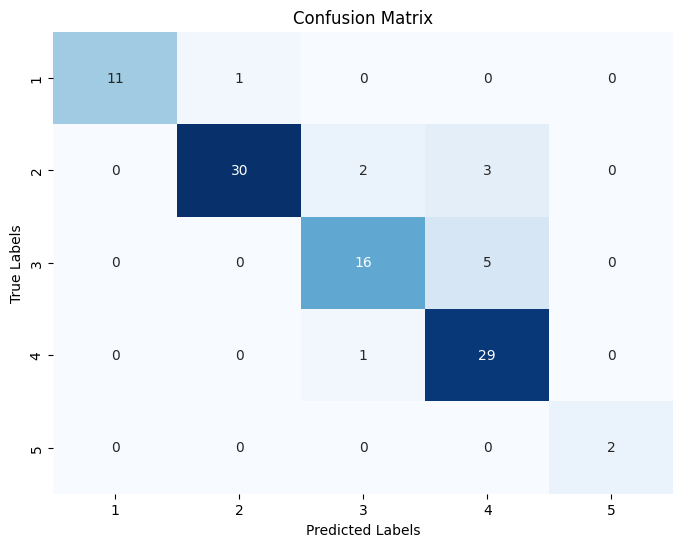

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(labelled_data['label'], train_predicted_labels)

# Create a DataFrame for better visualization
conf_df = pd.DataFrame(conf_matrix, index=sorted(labelled_data['label'].unique()), columns=sorted(labelled_data['label'].unique()))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(labelled_data["label"], train_predicted_labels)
precision = precision_score(
    labelled_data["label"], train_predicted_labels, average="weighted"
)
recall = recall_score(
    labelled_data["label"], train_predicted_labels, average="weighted"
)
f1 = f1_score(labelled_data["label"], train_predicted_labels, average="weighted")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.88
Precision: 0.89
Recall: 0.88
F1 Score: 0.88


## **Save Labelled Test Data**

In [28]:
test_data['BERT_label'] = test_predicted_labels

In [29]:
test_data = test_data.drop(columns = ['study_id','label'])

In [30]:
test_data

,body,BERT_label
0,The psychological impact of quarantine and how...,4
1,"Global, regional, and national incidence, prev...",4
2,A novel coronavirus outbreak of global health ...,2
3,COVID-19 and Italy: what next?,2
4,Structural racism and health inequities in the...,3
...,...,...
1237,Informing the Market: The Effect of Modern Inf...,3
1238,Winning by Losing: Evidence on the Long-run Ef...,4
1239,Employment and Wage Insurance within Firms: Wo...,3
1240,Why Does Fast Loan Growth Predict Poor Perform...,4


In [52]:
pd.set_option('display.max_colwidth', None)
test_data[test_data['BERT_label']==1]

,body,BERT_label
7,Hyperinflammatory shock in children during COVID-19 pandemic,1
17,COVID-19: towards controlling of a pandemic,1
42,Parenting in a time of COVID-19,1
69,"If the world fails to protect the economy, COVID-19 will damage health not just now but also in the future",1
114,Quantum internet: A vision for the road ahead,1
178,Waste in covid-19 research,1
261,Convalescent Plasma to Treat COVID-19,1
390,COVID-19 and Cardiovascular Disease,1
458,Compassionate Use of Remdesivir for Patients with Severe Covid-19,1
465,Nivolumab plus Ipilimumab in Lung Cancer with a High Tumor Mutational Burden,1


In [54]:
test_data[test_data['BERT_label']==5]

,body,BERT_label
367,Fixed Duration of Venetoclax-Rituximab in Relapsed/Refractory Chronic Lymphocytic Leukemia Eradicates Minimal Residual Disease and Prolongs Survival: Post-Treatment Follow-Up of the MURANO Phase III Study,5
647,The causal effects of education on health outcomes in the UK Biobank,5
728,How and why studies disagree about the effects of education on health: A systematic review and meta-analysis of studies of compulsory schooling laws,5
1205,The role of education in the Environmental Kuznets Curve. Evidence from Australian data,5


In [60]:
test_data[test_data['BERT_label']==4].head(1)

,body,BERT_label
0,The psychological impact of quarantine and how to reduce it: rapid review of the evidence,4


In [119]:
test_data.to_csv('/Users/vladandreichuk/Desktop/git_reps/practical-data-science-tutorial/data/Full_Dataset_Labelled_BERT', index=False) 

Tokenized Text: ['fixed', 'duration', 'of', 've', '##net', '##oc', '##la', '##x', '-', 'ri', '##tu', '##xi', '##ma', '##b', 'in', 're', '##la', '##pse', '##d', '/', 'ref', '##rac', '##tory', 'chronic', 'l', '##ym', '##ph', '##oc', '##ytic', 'leukemia', 'era', '##dicate', '##s', 'minimal', 'residual', 'disease', 'and', 'pro', '##long', '##s', 'survival', ':', 'post', '-', 'treatment', 'follow', '-', 'up', 'of', 'the', 'mu', '##rano', 'phase', 'iii', 'study']
Token IDs: tensor([[  101,  4964,  9367,  1997,  2310,  7159, 10085,  2721,  2595,  1011,
         15544,  8525,  9048,  2863,  2497,  1999,  2128,  2721, 29251,  2094,
          1013, 25416, 22648,  7062, 11888,  1048, 24335,  8458, 10085, 21252,
         25468,  3690, 16467,  2015, 10124, 21961,  4295,  1998,  4013, 10052,
          2015,  7691,  1024,  2695,  1011,  3949,  3582,  1011,  2039,  1997,
          1996, 14163, 20770,  4403,  3523,  2817,   102]])
Attention Weights Shape: (57, 57)


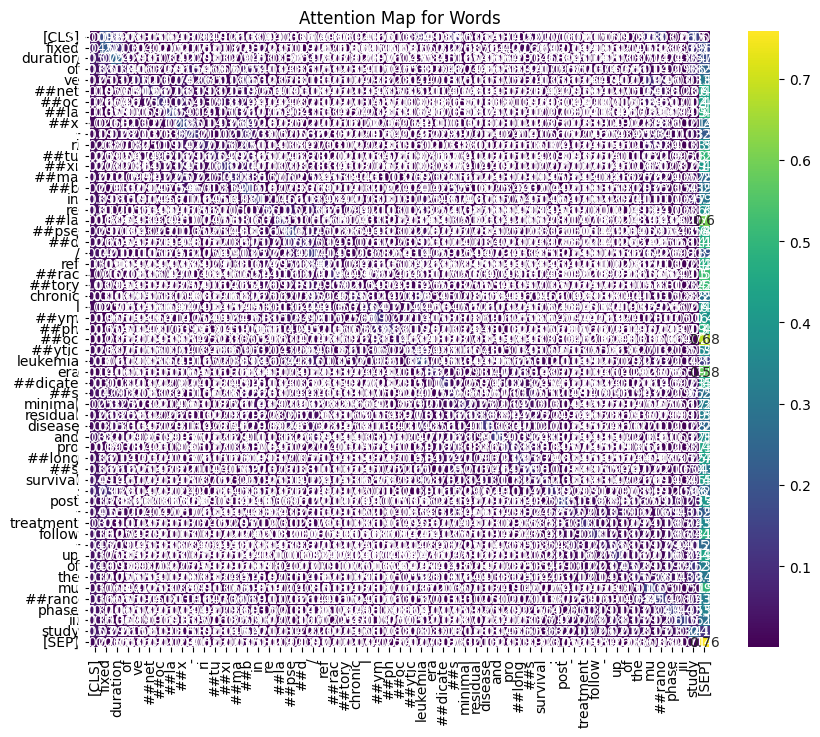

Tokenized Text: ['the', 'causal', 'effects', 'of', 'education', 'on', 'health', 'outcomes', 'in', 'the', 'uk', 'bio', '##bank']
Token IDs: tensor([[  101,  1996, 28102,  3896,  1997,  2495,  2006,  2740, 13105,  1999,
          1996,  2866, 16012,  9299,   102]])
Attention Weights Shape: (15, 15)


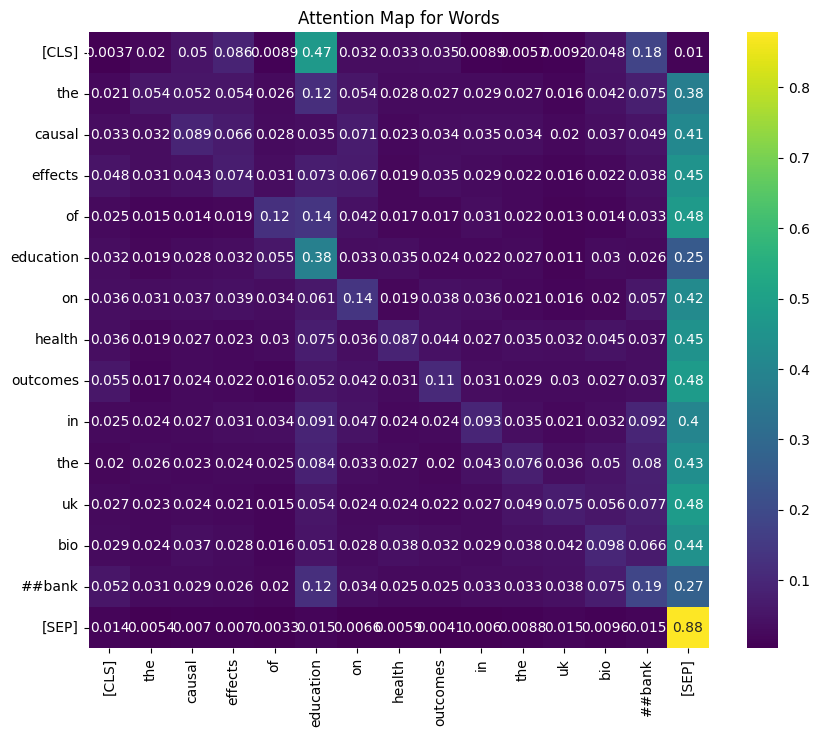

Tokenized Text: ['how', 'and', 'why', 'studies', 'disagree', 'about', 'the', 'effects', 'of', 'education', 'on', 'health', ':', 'a', 'systematic', 'review', 'and', 'meta', '-', 'analysis', 'of', 'studies', 'of', 'compulsory', 'schooling', 'laws']
Token IDs: tensor([[  101,  2129,  1998,  2339,  2913, 21090,  2055,  1996,  3896,  1997,
          2495,  2006,  2740,  1024,  1037, 11778,  3319,  1998, 18804,  1011,
          4106,  1997,  2913,  1997, 14770, 14118,  4277,   102]])
Attention Weights Shape: (28, 28)


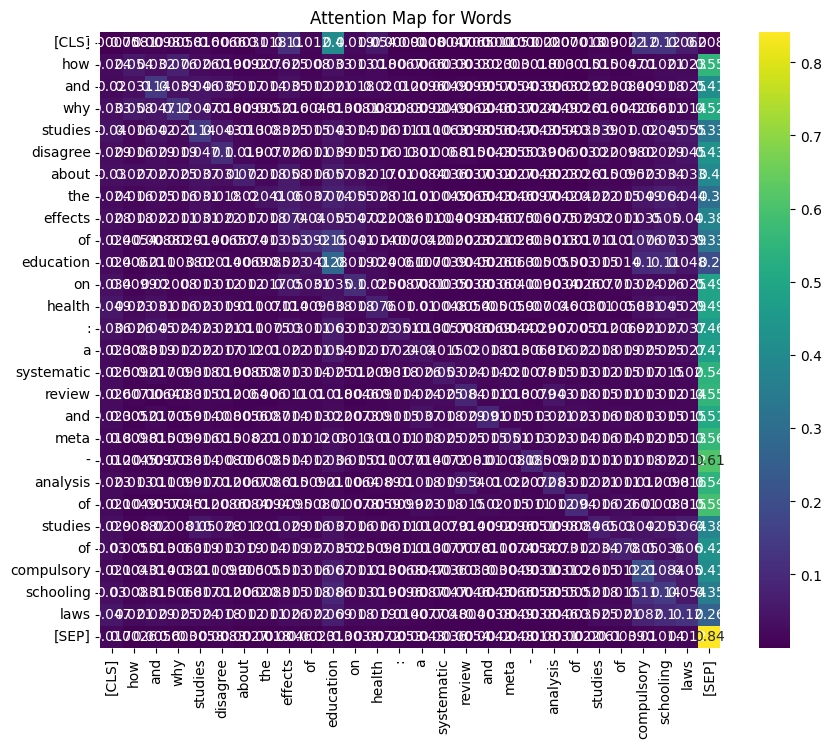

Tokenized Text: ['the', 'role', 'of', 'education', 'in', 'the', 'environmental', 'ku', '##z', '##nets', 'curve', '.', 'evidence', 'from', 'australian', 'data']
Token IDs: tensor([[  101,  1996,  2535,  1997,  2495,  1999,  1996,  4483, 13970,  2480,
         22781,  7774,  1012,  3350,  2013,  2827,  2951,   102]])
Attention Weights Shape: (18, 18)


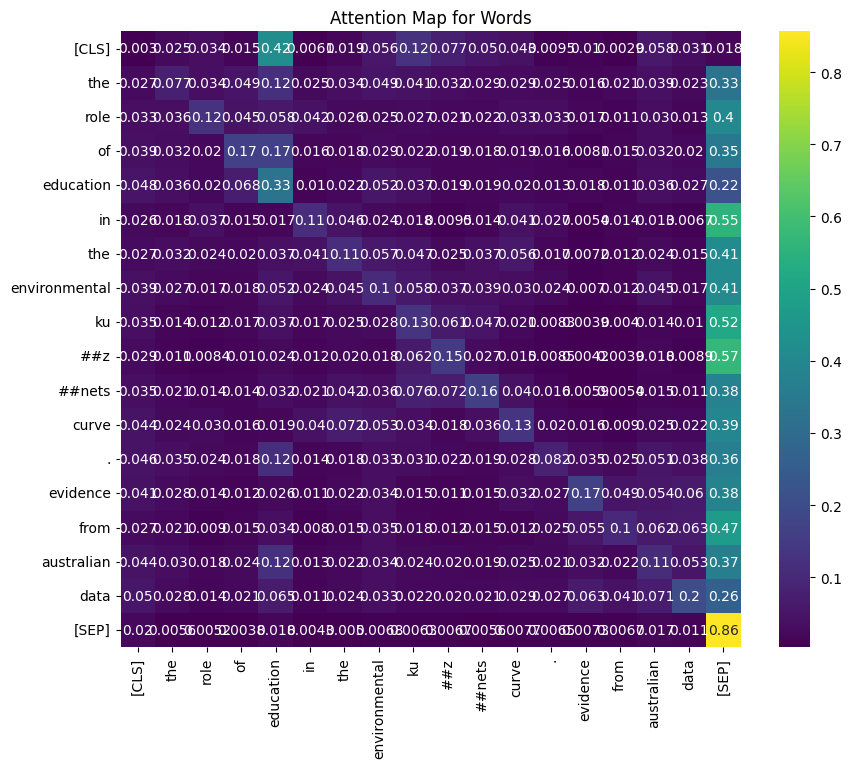

In [62]:
import torch.nn.functional as F
# Tokenize a sample sentence
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
for text in test_data[test_data['BERT_label'] == 5]['body']:
    tokens = tokenizer(text, return_tensors="pt")

    # Load BERT model
    best_model = BERT_unfreeze.load_from_checkpoint('/Users/vladandreichuk/Desktop/git_reps/practical-data-science-tutorial/models/BERT_metrics/lightning_logs/version_0/checkpoints/epoch=6-step=112.ckpt')

    # Obtain logits
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]
    logits = best_model(input_ids,attention_mask)

    # Apply softmax to obtain probabilities
    probabilities = F.softmax(logits, dim=1)

    # Obtain attention weights
    outputs = best_model.bert(input_ids, attention_mask=attention_mask, output_attentions=True)
    attention_weights = outputs.attentions[-1][0].mean(dim=0).detach().numpy()

    # Print tokenization information
    tokenized_text = tokenizer.tokenize(text)
    print("Tokenized Text:", tokenized_text)
    print("Token IDs:", input_ids)
    print("Attention Weights Shape:", attention_weights.shape)

    # Plot attention heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, annot=True, cmap="viridis", xticklabels=tokenizer.convert_ids_to_tokens(input_ids.flatten()), yticklabels=tokenizer.convert_ids_to_tokens(input_ids.flatten()))
    plt.title("Attention Map for Words")
    plt.show()